In [1]:
# Steps included in this file

# Install and import dependencies
# Read in image, Grayscale and Blur
# Apply filter and find edges for localization
# Find contours and Apply mask
# Use Easy OCR to read text
# Render result

# Import dependencies

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

# Read in image, Grayscale and Blur

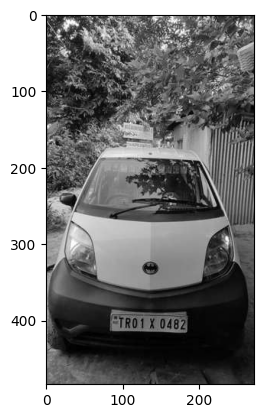

In [4]:
img = cv2.imread("TR5.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)  # Increase contrast

# Apply filter and find edges for localization

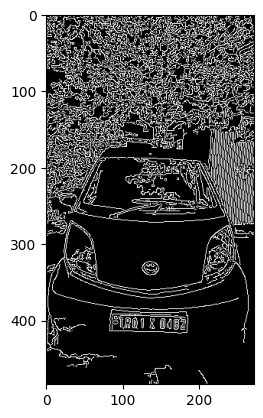

In [6]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # Noise Reduction
edged = cv2.Canny(bfilter, 30, 200) # Edge Detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

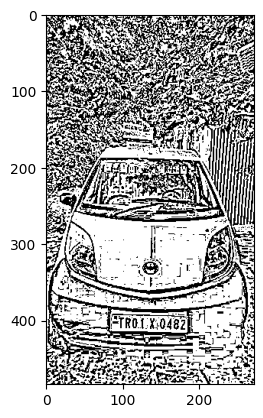

In [7]:
# Noise Reduction (replace bfilter line if you want to test this instead)
bfilter = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY, 11, 2)  # Adaptive Thresholding
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB))  # To view the output

# Find contours and Apply mask

In [8]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

In [9]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [10]:
location

array([[[ 85, 387]],

       [[ 83, 414]],

       [[184, 416]],

       [[183, 389]]], dtype=int32)

In [11]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask = mask)

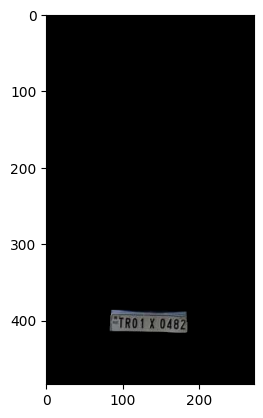

In [12]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [13]:
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

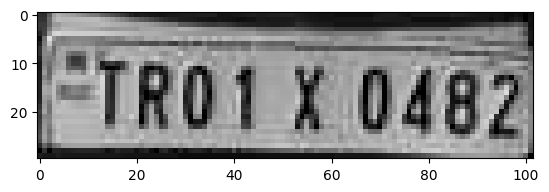

In [14]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

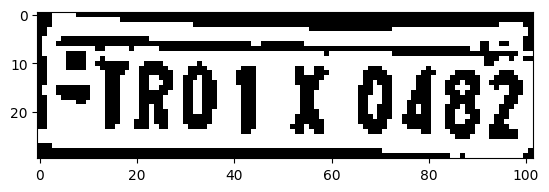

In [15]:
# Further preprocessing for OCR
preprocessed_image = cv2.GaussianBlur(cropped_image, (3,3), 0)
preprocessed_image = cv2.adaptiveThreshold(preprocessed_image, 255, 
                                           cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                           cv2.THRESH_BINARY, 11, 2)
plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))  # To view the result

# Use Easy OCR to read text

In [16]:
reader = easyocr.Reader(['en'], gpu=False)  # Add contrast settings in `reader.readtext`
result = reader.readtext(preprocessed_image, detail=1, contrast_ths=0.7, adjust_contrast=0.5)

result

Using CPU. Note: This module is much faster with a GPU.


[([[0, np.int32(2)], [102, np.int32(2)], [102, 30], [0, 30]],
  'FRO1< 0487',
  np.float64(0.024072800161518075))]

In [17]:
# Resize the cropped image
scale_percent = 150  # Scale by 150%
width = int(cropped_image.shape[1] * scale_percent / 100)
height = int(cropped_image.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_LINEAR)

# Use `resized` in OCR
result = reader.readtext(resized)

In [18]:
result

[([[np.int32(13), np.int32(9)],
   [153, np.int32(9)],
   [153, 45],
   [np.int32(13), 45]],
  'TROLX 0482 ',
  np.float64(0.4611046530567263))]

# Render result

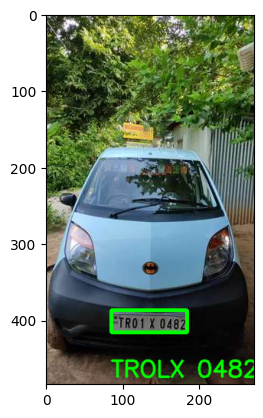

In [19]:
if result:
    text = result[0][-2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1] + 60), 
                      fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
else:
    print("No text detected.")